# Modeling <a id=''></a>

## Table of Contents
  * 1 [Import libriaries and Load data](#load_data)
  * 2 [Prepare data](#prepare_data)
  * 3 [Overview of recommender systems](#overview)
    * 3.1 [Two primary approaches](#approaches)
    * 3.2 [Deep learning-based recommender systems](#DL_rec_systems)
  * 4 [Modelling](#modelling)
    * 4.1 [Item2Vec and hierarchical Item2Vec models](#item2vec)
    * 4.2 [Hyperparameters](#hyperparameters)
      * 4.2.1 [Regularization parameter $\lambda_{cat}$](#lambda_cat)
      * 4.2.2 [Embedding dimension $dim_{embed}$](#dim_embedding)
      * 4.2.3 [Threshold for item frequency $f_{thresh}$](#f_tresh)
      * 4.2.4 [Learning rate and batch size](#learning_rate)
      * 4.2.5 [Loss function](#loss_function)
      * 4.2.6 [Similarity measure](#similarity_measure)
    * 4.3 [Hyperparameter tuning](#hyperparameter_tuning)
      * 4.3.1 [Embedding dimension](#tuning_dim_embed)
      * 4.3.2 [learning rate and batch size](#tuning_lr)
      * 4.3.3 [Regularization parameter $\lambda_{cat}$](#tuning_lam_cat)
  * 5 [Evaluation](#evaluation)
  * 6 [Conclusion](#conclusion)

## 1 Import libraries and Load data<a id='load_data'></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import json

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

from itertools import permutations, chain

from HuffmanTree import HuffmanNode,build_huffman_tree,generate_codebook,visualize_huffman_tree
from CategoryTree import TreeNode, build_tree, add_to_node, build_category_tree, get_path
from parameters import Params
from ItemMap import ItemMap
from HierarchicalItem2Vec import HierarchicalItem2Vec, Trainer
from batch_tool import BatchToolItem # this is obsolete as of Sep 25, 2025

pd.options.mode.copy_on_write = True
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

print('torch version: ', torch.__version__)
print('numpy version: ', np.__version__)


torch version:  2.2.0
numpy version:  1.25.2


In [2]:
df_evt= pd.read_csv('events_df.csv')
df_cat= pd.read_csv('category_df.csv')

df_trs = df_evt[(df_evt['event'] == 'transaction') & (df_evt['categoryid']> -1)]
df_freq = df_trs.groupby('itemid').agg(frequency = pd.NamedAgg(column='itemid', aggfunc='size'),
                                      categoryid = pd.NamedAgg(column='categoryid',aggfunc= 'first')).reset_index()

## 2 Prepare data<a id='prepare_data'></a>

In [3]:
df_items = df_trs.groupby(['visitorid','session_by_day']).agg(items = pd.NamedAgg(column='itemid', aggfunc=list)).reset_index()
print(df_items.count())

df_filtered = df_items[df_items['items'].apply(len) > 1]
print(df_filtered.count())

visitorid         13027
session_by_day    13027
items             13027
dtype: int64
visitorid         3055
session_by_day    3055
items             3055
dtype: int64


**To optimize model performance, we apply data pruning to remove low-frequency or unused items. Such items can degrade the quality of learned embeddings by introducing noise and distorting the structure of shared internal nodes in the Huffman tree, which plays a key role in efficient hierarchical softmax computation.**

In [4]:
items = df_filtered['items'].tolist()

flat = list(chain.from_iterable(items))
set_items = set(flat)

print(df_freq.count())
df_freq = df_freq.loc[df_freq['itemid'].isin(set_items)]
df_freq.count()

itemid        11645
frequency     11645
categoryid    11645
dtype: int64


itemid        7547
frequency     7547
categoryid    7547
dtype: int64

In [5]:
df_freq['frequency'].value_counts()

frequency
1      4025
2      1705
3       780
4       399
5       222
6       114
7        85
8        46
9        40
10       25
11       25
12       17
13        9
14        8
19        6
15        5
16        5
20        3
27        2
38        2
18        2
17        2
31        2
25        2
46        2
23        2
97        1
41        1
92        1
37        1
29        1
33        1
28        1
35        1
32        1
45        1
22        1
133       1
Name: count, dtype: int64

In [6]:
test_items = [461686,119736,213834,7943,312728] # highest frequency items
do_test = False

inputs = []
outputs = []
for items_in_session in items:
    
    pairs = list(permutations(items_in_session, 2))
    for pair in pairs:
        target_id, context_id = pair[0],pair[1]
        if target_id not in test_items and context_id not in test_items and do_test:
            continue
        inputs.append([target_id])
        outputs.append(context_id)
        
# Convert to torch.tensor
X = torch.tensor(inputs, dtype=torch.long)
y = torch.tensor(outputs, dtype=torch.long)

# Split using train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Wrap in TensorDataset
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

## 3 Overview of Recommender Systems<a id='overview'></a>

### 3.1 Two primary approaches<a id='approaches'></a>

*Recommender systems* suggest items to users based on their preferences, behavior, or similarities with others. They're widely used in platforms like Netflix, Amazon, Spotify, and YouTube. The primary goal is to predict a user’s preferences and recommend items they are likely to engage with such as movies, products, news articles, or even people. There are mainly two core types of recommender systems, **collaborative filtering** and **content-based filtering**. 

**Collaborative filtering** can be further divided into:
* *User-based filtering*, which identifies users with similar preferences and recommends items those users have liked.
* *Item-based filtering*, which finds items similar to those the user has previously liked and recommends them.

Similarity between users or items is typically computed using distance or similarity measures such as *Euclidean distance, Pearson correlation*, or *cosine similarity*. It's important to note that in collaborative filtering, item similarity is not based on the inherent features of the items, but rather on user interaction patterns. Item-based collaborative filtering is particularly effective in systems where the number of users significantly exceeds the number of items. 
However, collaborative filtering has several limitations:

- Data sparsity: User-item interaction matrices are often sparse, making it difficult to identify meaningful patterns.
- Cold start: The system struggles to make recommendations for new users or new items due to a lack of interaction data.
- Scalability: Performance can degrade as the number of users or items grows.
- Popularity bias: Tends to over-recommend popular items, reducing personalization and diversity.
- Lack of Interpretability: Recommendations are based on patterns in user behavior, not explicit item attributes.
- Gray sheep problem: Users with unique or atypical preferences may receive poor recommendations.

**Content-based filtering**, on the other hand, recommends items that are similar to those a user has liked in the past. These similarities are determined based on item attributes or features, such as categories, tags, genres, or other metadata. This approach can help address some of the limitations of collaborative filtering.

- No Need for Other Users' Data: Recommendations are based solely on the user’s own preferences and item features.
- Handles Cold Start (User Side): Can recommend items to new users after only a few interactions.
- Interpretable Recommendations.
- Less prone to recommending only popular items.
- Privacy-Friendly: Doesn’t require analyzing other users’ data.




### 3.2 Deep learning-based recommender systems<a id='DL_rec_systems'></a>   


In recent years, deep learning-based recommender systems have gained prominence due to their superior performance and ability to model complex, non-linear relationships between users and items. The following points summarize their key advantages over traditional methods:

- Better at Capturing Non-Linear and Complex Patterns
- Better at Cold Start and Sparse Data
- Effective Feature Representation (Embeddings): can automatically learn *dense, low-dimensional representations (embeddings)* of users and items from sparse interaction data
- Integration of Multiple Data Types (Multimodal Inputs)
- Personalized and Context-Aware Recommendations: Deep models can learn user-specific behaviors, preferences, and temporal patterns.

Deep learning models excel at capturing high-level patterns and personalization through architectures such as deep neural networks, convolutional neural networks (CNNs), recurrent neural networks (RNNs), and attention-based mechanisms. As a result, they often outperform traditional approaches, particularly in large-scale and dynamic recommendation environments.


## 4 Modeling <a id='modelling'></a>

### 4.1 Item2Vec and hierarchical Item2Vec models<a id='item2vec'></a>   

This project focuses on the Item2Vec model, which is based on the Word2Vec architecture originally developed for learning optimized word embeddings in natural language processing (NLP). By drawing an analogy between sequences of words and sequences of user-item interactions, Item2Vec learns dense vector representations of items that capture similarity and co-occurrence patterns. This results in more effective recommendations through meaningful item embeddings.

Item2Vec is an item-based collaborative filtering technique and, as such, inherits some of the limitations discussed in the previous section, such as cold-start problems and a lack of content awareness. To address these issues, we explore a hybrid approach called Hierarchical Item2Vec, which integrates hierarchical content-based information into the embedding process. This method helps mitigate the shortcomings of purely collaborative approaches by incorporating category-level knowledge.

Next, we will explore and fine-tune the model architecture and its components.

### 4.2 Hyperparameters<a id='hyperparameters'></a>  

To optimize model performance, we consider the following **hyperparameters**:


* $\lambda_{cat}$ 
* Embedding dimension $dim_{embed}$ 
* Threshold for item frequency $f_{thresh}$
* Learning rate 
* Loss function = {Negative sampling, Hierarchical softmax}
* Similarity measure: cosine similarity, distance


#### 4.2.1 Regularization parameter $\lambda_{cat}$<a id='lambda_cat'></a> 

The value of $\lambda_{cat}$ regulates the strength of alignment between item embeddings and their respective category embeddings.

We will select the following values during hyperparameter tuning:: 

<span style="color:red"> $\lambda_{cat}$ = {0, 0.1, 1, 10} </span>

| $\lambda_{\text{cat}}$ Value                 | Meaning / Effect                                                                 | When to Use                                                           |
| -------------------------------------------- | -------------------------------------------------------------------------------- | --------------------------------------------------------------------- |
| **0**                                        | No category alignment at all. Equivalent to Item2Vec.            | Baseline comparison; when category data is noisy or not useful.       |
| **1 $\times 10^{-4}$ to 1 $\times 10^{-3}$** | Very weak alignment. Minor influence from category embeddings.                   | Categories are somewhat useful, but item-level patterns dominate.     |
| **1 $\times 10^{-2}$ to 0.1**              | Moderate alignment. Balanced influence between item behavior and category info.  | Often a good starting point for tuning; works well in many scenarios. |
| **0.1 to 1.0**                           | Strong alignment. Item embeddings are pulled significantly toward category ones. | When categories are well-defined and strongly predictive.             |
| **>1.0**                                   | Very strong alignment. Item embeddings may lose individuality.                   | Only use if category structure is known to be highly reliable.        |


#### 4.2.2 Embedding dimension $dim_{embed}$  <a id='dim_embedding'></a> 

The optimal embedding dimension depends on both the number of items and the underlying characteristics of the data. In our case, the dataset contains approximately 7,000 items suitable for training. Given this scale, we experiment with 

<span style="color:red"> embedding dimensions $dim_{embed}$ = {32, ... , 128}</span>. 

These values strike a balance between model capacity and generalization: smaller dimensions may not capture enough semantic information, while larger dimensions risk overfitting and increased computational cost. Through experiments, we aim to identify the dimension that provides the best trade-off between performance and efficiency.

#### 4.2.3 Threshold for item frequency $f_{thresh}$ <a id='f_tresh'></a> 

#### 4.2.4 Learning rate and batch size<a id='learning_rate'></a> 

Learning rate and batch size are critical hyperparameters that significantly influence model convergence and overall performance. A smaller learning rate may lead to more stable convergence but slower training, while a larger batch size can improve training efficiency but may reduce generalization.

<span style="color:red"> Learning rate = {0.005, 0.01, 0.02} </span>

<span style="color:red"> Batch size = {8, 16, 32, 64, 128} </span>

#### 4.2.5 Loss function <a id='loss_function'></a> 

The **Negative Sampling** method updates only a small number of negative samples along with the true target, significantly reducing computational cost. While it is fast, simple, and easily parallelizable, it relies on a stochastic approximation of the softmax function. As a result, it is sensitive to the choice of sampling strategy and does not produce outputs with a clear probabilistic interpretation. It is particularly suitable for models with a large output space (e.g., over 10,000 items), where computing the full softmax would be computationally prohibitive.

The **Hierarchical Softmax** method

Considering our training data contains fewer than 10K items, and part of our focus is on rare items and their structure, hierarchical softmax is a more effective choice due to its ability to leverage shared paths in the tree, improving representation for infrequent items.

#### 4.2.6 Similarity measure <a id='similarity_measure'></a> 

Since our model learns embeddings that encode semantic relationships between items, **cosine similarity** is the most suitable similarity measure for our study. It effectively captures the orientation (rather than magnitude) of embedding vectors. This is particularly important in high-dimensional spaces, where the angle between vectors provides a more meaningful measure of similarity than Euclidean distance. This makes it especially well-suited for tasks such as *ranking, retrieval, and recommendation*.

Furthermore, cosine similarity can be used to help determine the optimal embedding dimension. If the dimension is too small, item vectors tend to cluster tightly together, resulting in uniformly high cosine similarity even before training, which limits the model's ability to distinguish between items. A good strategy is to choose an embedding dimension large enough so that cosine similarities between random item pairs are below **0.4** *before* training, while ensuring that co-occurring items exhibit high similarity, typically above **0.7-0.8**, *after* training.

| Cosine Similarity Score | Interpretation                                          |
| ----------------------- | ------------------------------------------------------- |
| **> 0.8**               | Very high similarity (strong recommendation candidates) |
| **0.6 – 0.8**           | High similarity (related items, likely of interest)     |
| **0.4 – 0.6**           | Moderate similarity (some shared context)               |
| **< 0.4**               | Low or weak similarity                                  |


### 4.3 Hyperparameter tuning<a id='hyperparameter_tuning'></a>  

[ Default configuration for training ]

In [7]:
# Huffman Tree
begin_index = 500000
imap = ItemMap(df_freq, df_cat)
itemmap = imap.dict_items
flat_itemmap = imap.flat_items
total_inner_nodes, huff_tree = build_huffman_tree(begin_index, None, flat_itemmap, None)
print(f'Total number of inner nodes : {total_inner_nodes}')

total number of items  7547  total number of categories  1670
Total number of inner nodes : 7546


In [8]:
# Category Tree
root_code = 10000
cat_tree =  build_category_tree(root_code, df_cat, itemmap)

In [9]:
params = Params()
params.model_name = 'HierarchicalItem2Vec'
params.model_dir = "weights/{}".format(params.model_name)
params.checkpoint_frequency = 10
params.dim_embedding = 72
params.lambda_cat = 0
params.batch_size = 64
params.n_epochs = 5 # 1 for test
os.makedirs(params.model_dir, exist_ok=True)

In [10]:
hi2v = HierarchicalItem2Vec(imap, params, huff_tree, cat_tree)
batchtool = BatchToolItem(imap, params)
optimizer = torch.optim.Adam(params = hi2v.parameters(), lr=0.01)

In [11]:
trainer = Trainer(
        model=hi2v,
        params=params,
        optimizer=optimizer,
        train_iter=train_dataset,
        valid_iter=val_dataset,
        map=imap,
        method =batchtool,
        debug = 0
    )
trainer.test_tokens = [461686,119736,213834,7943,312728]
#trainer.train()

#### 4.3.1 Embedding dimension<a id='tuning_dim_embed'></a>  

To determine the optimal embedding dimension, we measure the average similarity between items prior to training across a range of dimension values. We select the embedding dimension at which the average similarity between the five most frequent items and their five nearest neighbors first drops below 0.4, ensuring that item similarities are not inflated due to an overly dense latent space.

In [12]:
os.makedirs('./output', exist_ok=True)
dim_embs = [32,48,64,72,80,96,112,128] 

for dim in dim_embs:
    params.dim_embedding = dim
    hi2v = HierarchicalItem2Vec(imap, params, huff_tree, cat_tree)
    trainer = Trainer(
        model=hi2v,
        params=params,
        optimizer=optimizer,
        train_iter=train_dataset,
        valid_iter=val_dataset,
        map=imap,
        method =batchtool,
        debug = 0
    )
    trainer.test_tokens = [461686,119736,213834,7943,312728]
    trainer.similarity_path = './output/dim'+ str(dim) + '.pt'
    trainer.do_test(topk= 5, save_results=True,print_test=False)
    

Save similarity matrix to  ./output/dim32.pt
Save similarity matrix to  ./output/dim48.pt
Save similarity matrix to  ./output/dim64.pt
Save similarity matrix to  ./output/dim72.pt
Save similarity matrix to  ./output/dim80.pt
Save similarity matrix to  ./output/dim96.pt
Save similarity matrix to  ./output/dim112.pt
Save similarity matrix to  ./output/dim128.pt


In [13]:
means=[]
for dim in dim_embs:
    fname = './output/dim'+ str(dim) + '.pt'
    data = torch.load(fname)
    similarity_matrix = data['similarity_matrix']
    means.append(similarity_matrix.topk(5).values.mean().item())

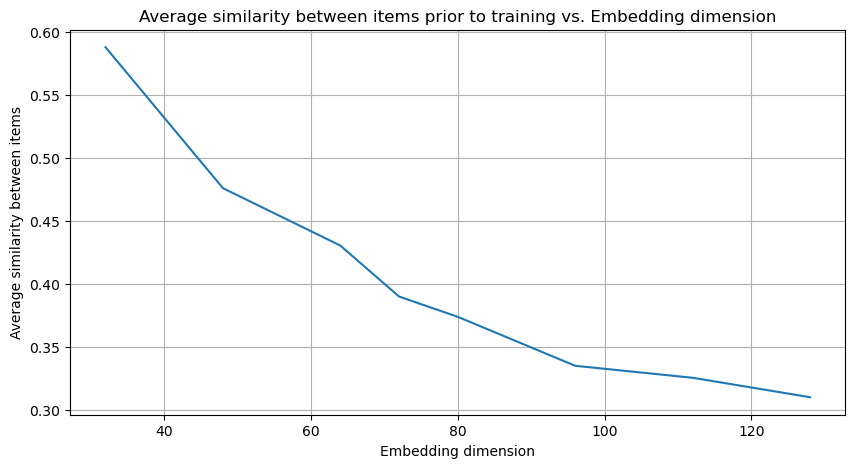

In [14]:
plt.figure(figsize=(10,5))
sns.lineplot(x=dim_embs, y=means)
plt.xlabel("Embedding dimension")
plt.ylabel("Average similarity between items")
plt.title("Average similarity between items prior to training vs. Embedding dimension")
plt.grid(True)
plt.show()

We select **72** as the optimal embedding dimension.

#### 4.3.2 Learning rate and batch size<a id='tuning_lr'></a>  

We optimize the batch size and learning rate while keeping the regularization parameter $\lambda_{cat}$ set to zero.

In [15]:
batch_sizes=[8, 16, 32, 64, 128]
learning_rates = [0.005, 0.01, 0.02]
for lr in learning_rates:
    for size in batch_sizes:
        params.batch_size = size
        params.dim_embedding = 72
        hi2v = HierarchicalItem2Vec(imap, params, huff_tree, cat_tree)
        optimizer = torch.optim.Adam(params = hi2v.parameters(), lr=lr)
        trainer = Trainer(
            model=hi2v,
            params=params,
            optimizer=optimizer,
            train_iter=train_dataset,
            valid_iter=val_dataset,
            map=imap,
            method =batchtool,
            debug = 0
        )
        trainer.test_tokens = [461686,119736,213834,7943,312728]
        trainer.loss_path = './output/loss_batchsize'+str(size)+'_lr'+str(lr)+'.json'
        trainer.similarity_path = './output/similarity_batchsize'+str(size)+'_lr'+str(lr)+'.pt'
        #trainer.train()

In [16]:
train_acc = [] 
valid_acc = [] 

for i, lr in enumerate(learning_rates):
    train_acc_temp =[]
    valid_acc_temp =[]
    for j, size in enumerate(batch_sizes):
        file = 'output/loss_batchsize'+str(size)+'_lr'+str(lr)+'.json'
        with open(file, 'r') as f:
            data = json.load(f)
        #print(data)
        train_acc_temp.append([ acc for acc in data['train']])
        valid_acc_temp.append([ acc for acc in data['valid']])
    train_acc.append(train_acc_temp)
    valid_acc.append(valid_acc_temp)
        

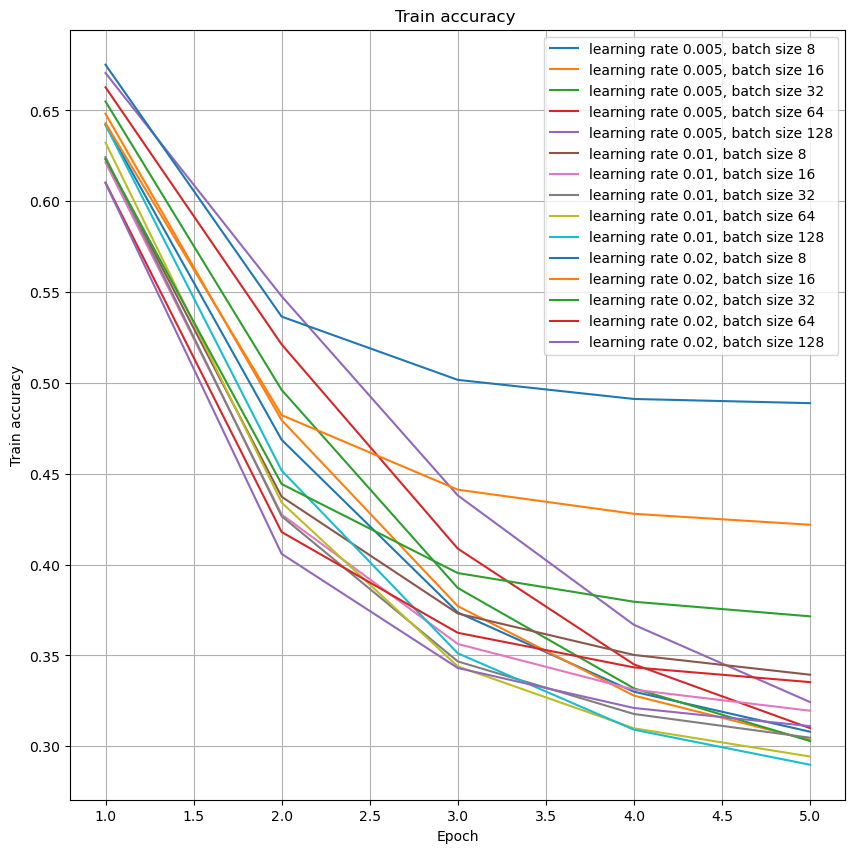

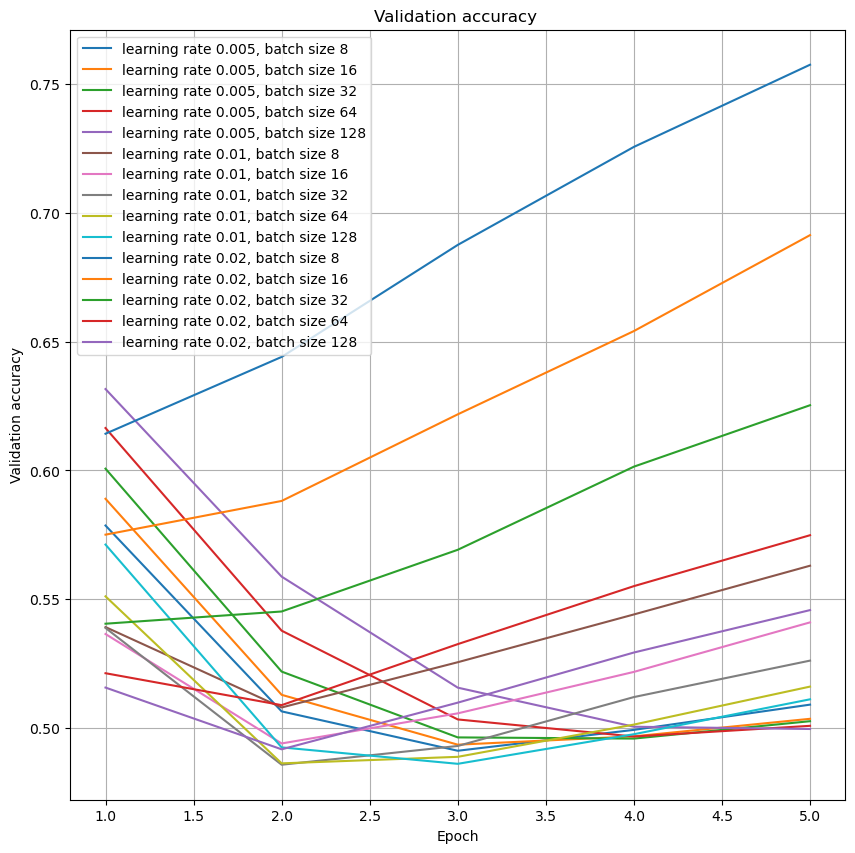

In [17]:
epochs= [i+1 for i in range(5)]
plt.figure(figsize=(10,10))
for i in range(len(learning_rates)):
    for j in range(len(batch_sizes)):
        sns.lineplot(x=epochs, y=train_acc[i][j], label=f'learning rate {learning_rates[i]}, batch size {batch_sizes[j]}')
plt.xlabel("Epoch")
plt.ylabel("Train accuracy")
plt.title("Train accuracy ")
plt.grid(True)
plt.show()

plt.figure(figsize=(10,10))
for i in range(len(learning_rates)):
    for j in range(len(batch_sizes)):
        sns.lineplot(x=epochs, y=valid_acc[i][j], label=f'learning rate {learning_rates[i]}, batch size {batch_sizes[j]}')
plt.xlabel("Epoch")
plt.ylabel("Validation accuracy")
plt.title("Validation accuracy ")
plt.grid(True)
plt.legend(loc='upper left')
plt.show()


The optimal learning rate and batch size are 0.01 and 64, respectively. 

#### 4.3.3 Regularization parameter $\lambda_{cat}$<a id='tuning_lam_cat'></a>

## 5 Evaluation <a id='evaluation'></a>

Save results with a dictionary {item1: (item2, similarity, category1, category2}
visualization with t-sne 

Test item groups: high-frequency, moderate-frequency items, cold items.
For problems at hand, ranking-based evaluation metrics such as Precision@k, Recall@k, NDCG, MAP are most appropriate.

* Precision at K
* Recall at K

## 6 Conclusion <a id='conclusion'></a>